In [1]:
%matplotlib inline

from functools import reduce
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Pandas Options
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 100)

#Set Seaborn Theme
sns.set_style('darkgrid')

In [53]:
#Querying and joining attributes.

query = """
WITH block_level AS (
  SELECT 
    SUBSTR(block.block_code, 0, 12) AS block_group
    , CASE WHEN fcc.block_code IS NULL THEN 0 ELSE 1 END AS int_avail
  FROM broadband.census_block block
  LEFT JOIN (SELECT block_code FROM broadband.fcc WHERE file_date = 201706) fcc
    ON block.block_code = fcc.block_code
  LEFT JOIN broadband.fcc_demography
    ON block.block_code = fcc_demography.block_code
  WHERE 
      fcc_demography.population_2016 > 0 
      AND fcc_demography.housing_unit_2016 > 0
),
block_group_level AS ( 
  SELECT 
    block_group
    , AVG(int_avail) AS broad_avail_per
  FROM block_level
  GROUP BY block_group
),
fund AS (
    SELECT DISTINCT SUBSTR(census_block, 0, 12) AS block_group
    FROM broadband.fund
)

SELECT DISTINCT
  block_group_level.block_group
  , block_group_level.broad_avail_per
  , SAFE_DIVIDE(tiger_acs.road_length, tiger_acs.land_area) AS road_density
  , tiger_acs.elev_mean
  , tiger_acs.elev_range
  , tiger_acs.winter_temp AS winter_temperature
  , SAFE_DIVIDE(tiger_acs.population, tiger_acs.land_area) AS population_density
  , tiger_acs.male_rate
  , tiger_acs.median_income
  , tiger_acs.median_age
  , tiger_acs.white_rate
  , tiger_acs.avg_years_of_edu
  , tiger_acs.unemployment_rate
  , SAFE_DIVIDE(tiger_acs.housing_units, tiger_acs.land_area) AS housing_density
  , tiger_acs.house_owner_rate
  , tiger_acs.newly_moved_household_rate
  , tiger_acs.newly_built_housing_rate
  , law.laws_against
  --, IFNULL(law.type, 'no_law') AS law_type
FROM block_group_level
LEFT JOIN fund
  ON block_group_level.block_group = fund.block_group
LEFT JOIN broadband.tiger_acs_2016 AS tiger_acs
  ON block_group_level.block_group = tiger_acs.block_group
LEFT JOIN broadband.laws_against_municipal_broadband law
  ON SUBSTR(block_group_level.block_group, 0, 2) = law.state_code
WHERE fund.block_group IS NULL
"""

all_data = pd.read_gbq(query, project_id='fccdsicapstone-218522', dialect='standard')

In [54]:
all_data.shape

(190223, 18)

In [52]:
all_data.shape

(215527, 18)

### Data Cleaning

Data completeness

In [55]:
all_data.count() / all_data.shape[0] * 100

block_group                   100.000000
broad_avail_per               100.000000
road_density                   99.969509
elev_mean                      99.971612
elev_range                     99.971612
winter_temperature             99.941647
population_density             99.969509
male_rate                      99.800234
median_income                  97.165432
median_age                     99.767115
white_rate                     99.800234
avg_years_of_edu               99.800234
unemployment_rate              99.714020
housing_density                99.969509
house_owner_rate               99.658296
newly_moved_household_rate     99.658296
newly_built_housing_rate       99.678272
laws_against                  100.000000
dtype: float64

In [56]:
data = all_data.dropna()

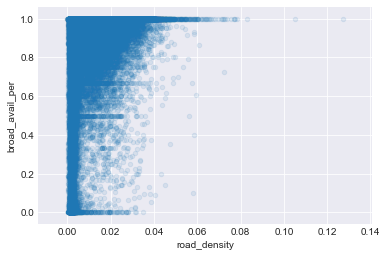

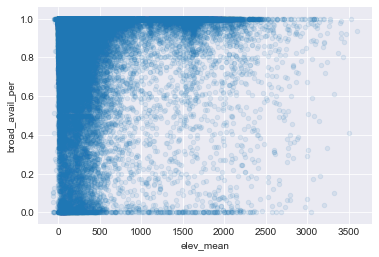

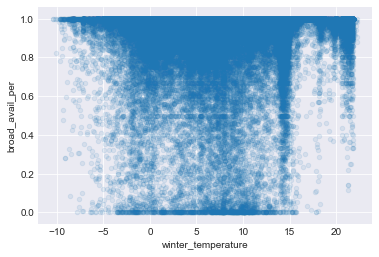

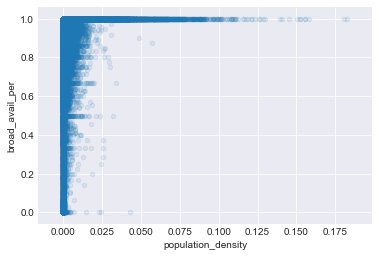

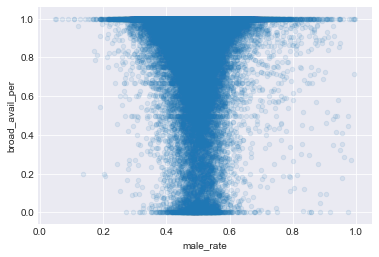

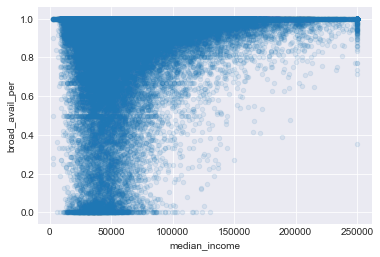

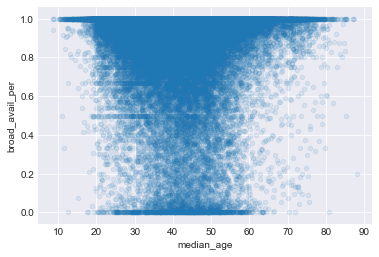

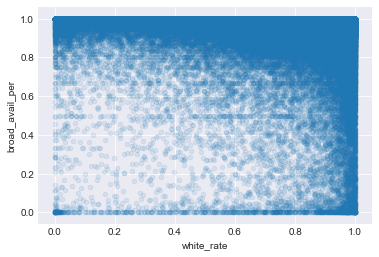

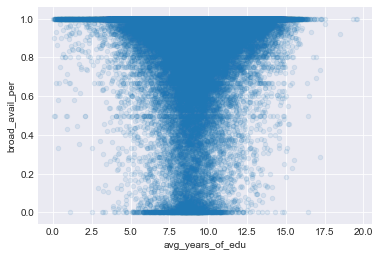

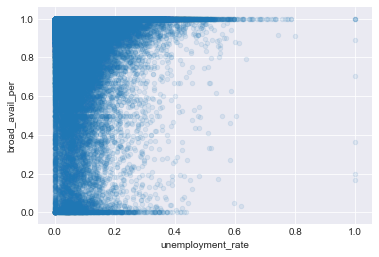

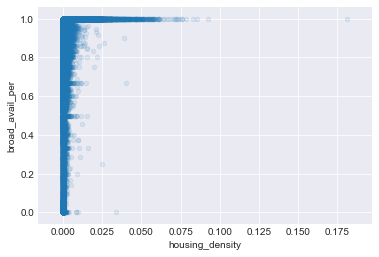

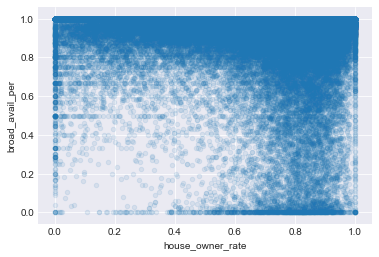

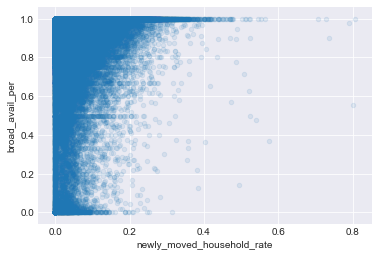

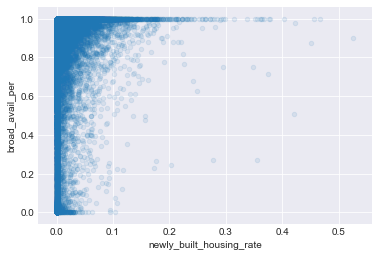

In [57]:
#Visualizing the Data.

for col in data.select_dtypes(include=[np.float]).columns[1:]:
    data.plot(x=col, y='broad_avail_per', kind='scatter', alpha=0.1)

Text(0.5,0,'Internet availability percentage')

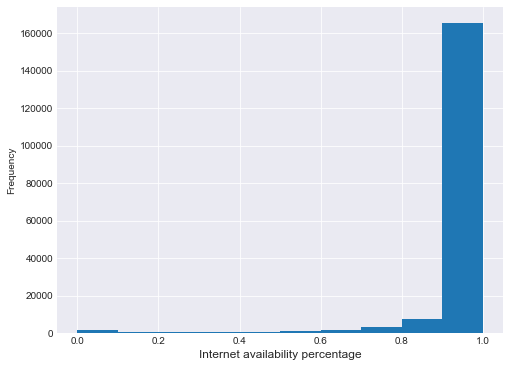

In [58]:
ax = data.broad_avail_per.plot(kind='hist', figsize=(8, 6))
ax.set_xlabel('Internet availability percentage', fontsize=12)

In [59]:
data.broad_avail_per.describe()

count    184766.000000
mean          0.956615
std           0.138864
min           0.000000
25%           0.991525
50%           1.000000
75%           1.000000
max           1.000000
Name: broad_avail_per, dtype: float64

In [60]:
full_coverage = (data.broad_avail_per == 1).sum() / data.shape[0] * 100
print('block_group with full coverage', full_coverage)
print('block_group without full coverage', 100 - full_coverage)

block_group with full coverage 74.63386120823095
block_group without full coverage 25.366138791769046


# Correlation Analysis

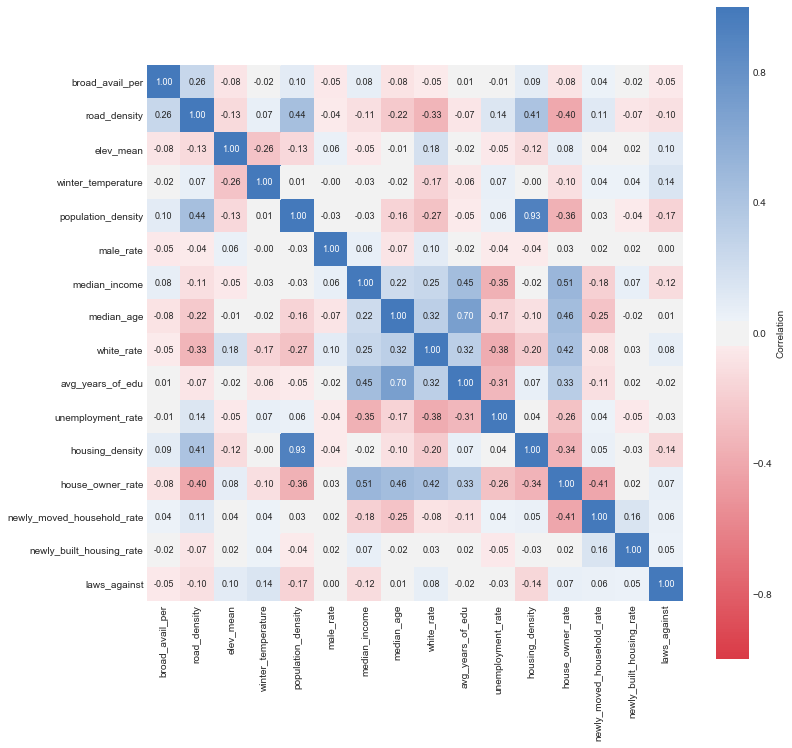

In [61]:
corr = data.corr()

fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corr, cmap=sns.diverging_palette(10, 250, as_cmap=True), square=True, 
            vmin=-1.0, vmax=1.0, annot=True, fmt='.2f', annot_kws={'size': 9},
            cbar_kws={'label': 'Correlation'}, ax=ax)

# Building a classification model.

In [62]:
pd.options.mode.chained_assignment = None
data['is_full_coverage'] = (data['broad_avail_per'] == 1)

In [63]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

target_col = 'is_full_coverage'
X = data.drop(columns=['broad_avail_per', 'block_group', target_col])
y = data[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [64]:
# Baseline with no tuning
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)

print('Grid Searched Train Score:', clf.score(X_train, y_train))
print('Grid Searched Test Score:', clf.score(X_test, y_test))

Grid Searched Train Score: 0.7974183422184937
Grid Searched Test Score: 0.7957460626725118


### Step 1: Tune Tuning tree-specific parameters
Going to tune max_depth and min_samples_split first as they will have the highest impact on model outcome.

In [69]:
param_fix = {'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 0.8, 'max_features': 'sqrt'}
param_grid = {'max_depth': range(8, 21, 2),
              'min_samples_split': range(50, 101, 10),
              'min_samples_leaf': range(20, 61, 10)}

clf = GradientBoostingClassifier(**param_fix)
grid_search = GridSearchCV(
    clf, param_grid, scoring='f1', cv=3, n_jobs=-1, verbose=3)
grid_search.fit(X_train, y_train)

print('Grid Searched Train Score:', grid_search.score(X_train, y_train))
print('Grid Searched Test Score:', grid_search.score(X_test, y_test))
print('Best Parameters:', grid_search.best_params_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 15.3min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 100.5min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 123.4min finished


Grid Searched Train Score: 0.9386941598740476
Grid Searched Test Score: 0.8823347320630116
Best Parameters: {'max_depth': 14, 'min_samples_leaf': 40, 'min_samples_split': 70}


### Step 2: Tuning subsample
Next, going to tune subsample to make predictions more robust

In [71]:
param_fix = {'learning_rate': 0.1, 'n_estimators': 100, 'max_features': 'sqrt',
             'max_depth': 14, 'min_samples_leaf': 40, 'min_samples_split': 70}
param_grid = {'subsample': np.linspace(0.6, 0.9, num=4)}

clf = GradientBoostingClassifier(**param_fix)
grid_search = GridSearchCV(clf, param_grid, scoring='f1', cv=3, n_jobs=-1, verbose=3)
grid_search.fit(X_train, y_train)

print('Grid Searched Train Score:', grid_search.score(X_train, y_train))
print('Grid Searched Test Score:', grid_search.score(X_test, y_test))
print('Best Parameters:', grid_search.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  7.1min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  7.3min finished


Grid Searched Train Score: 0.942792381634516
Grid Searched Test Score: 0.8832213380995755
Best Parameters: {'subsample': 0.9}


In [74]:
import joblib

joblib.dump(grid_search, 'tuned_broadband_model.joblib')
# grid_search = joblib.load('tuned_broadband_model.joblib')

['tuned_broadband_model.joblib']

In [85]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    fig = plt.figure(1, figsize=(10, 6), dpi=600)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=14)

    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)
    plt.tight_layout()

Confusion matrix, without normalization
[[ 4541  4833]
 [ 1979 25601]]


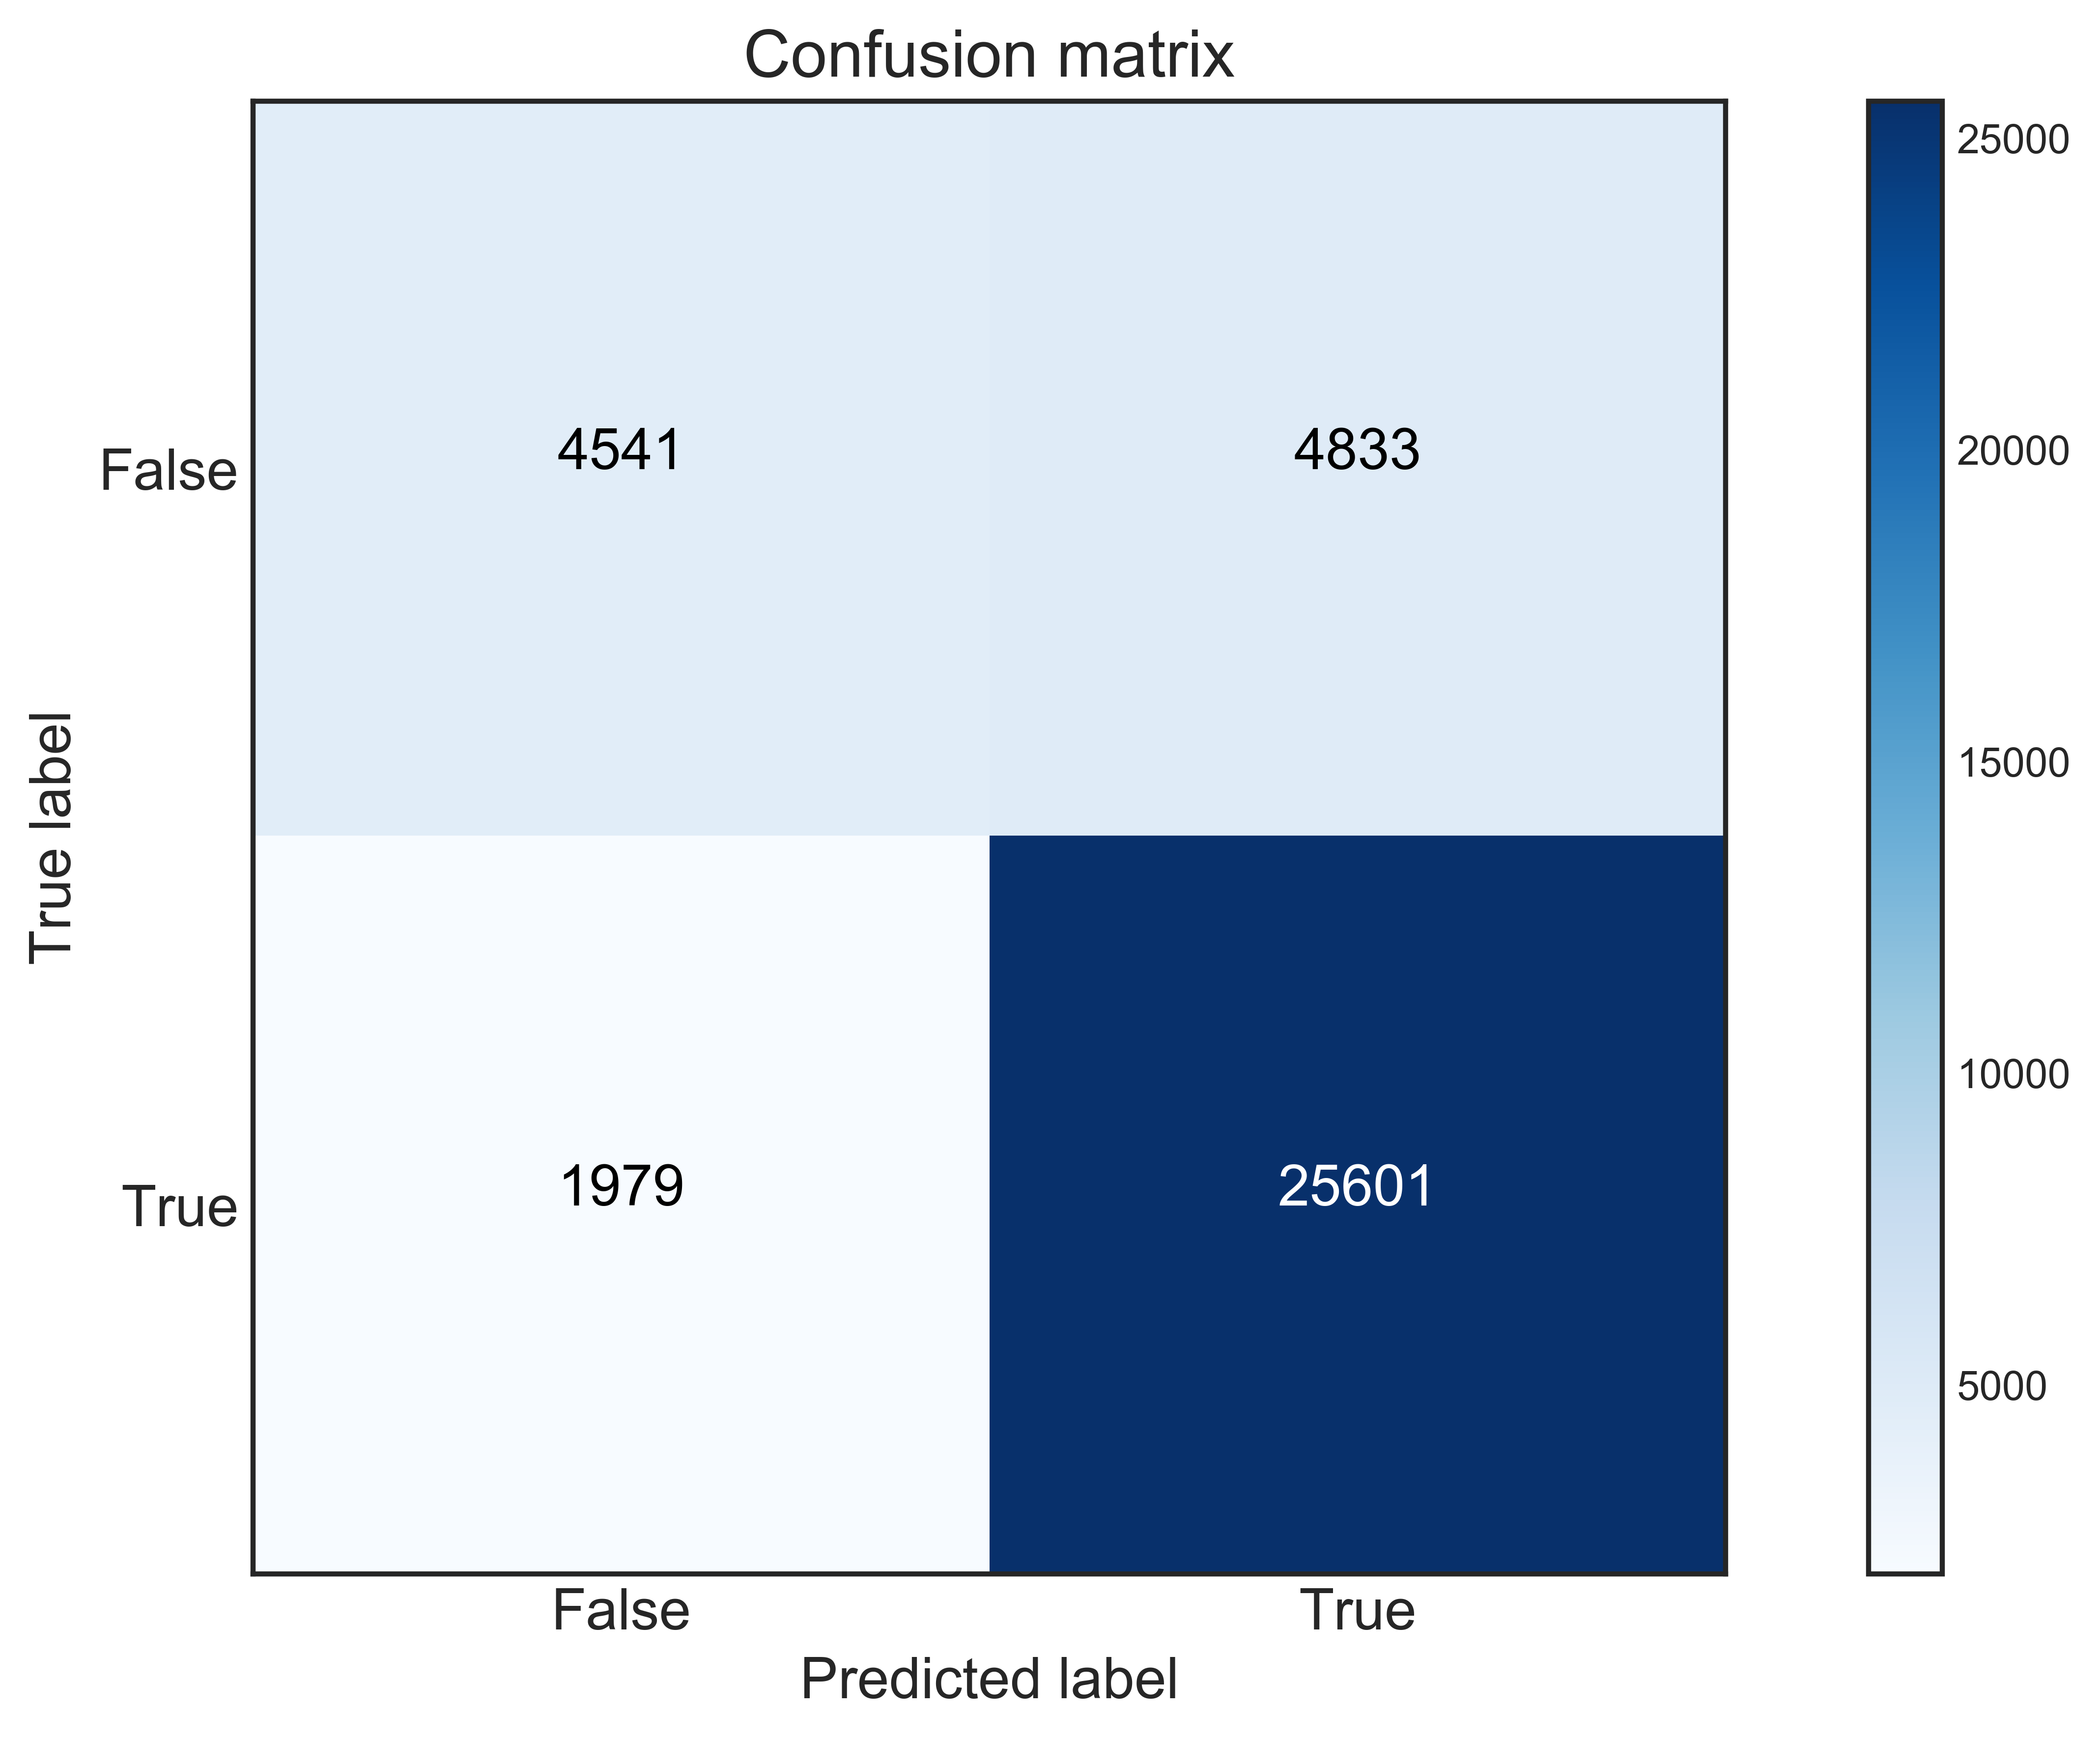

In [87]:
from sklearn.metrics import confusion_matrix


sns.set_style('white')
y_test_pred = grid_search.predict(X_test)
cm = confusion_matrix(y_test, y_test_pred)
plot_confusion_matrix(cm, classes=[False, True])

# Finding important features.

In [88]:
coef = pd.DataFrame(list(zip(X.columns, grid_search.best_estimator_.feature_importances_)),
                    columns=['feature', 'gini_coef'])
coef_sort = coef.sort_values('gini_coef', ascending=False)

Text(0.5,1,'Feature Importance')

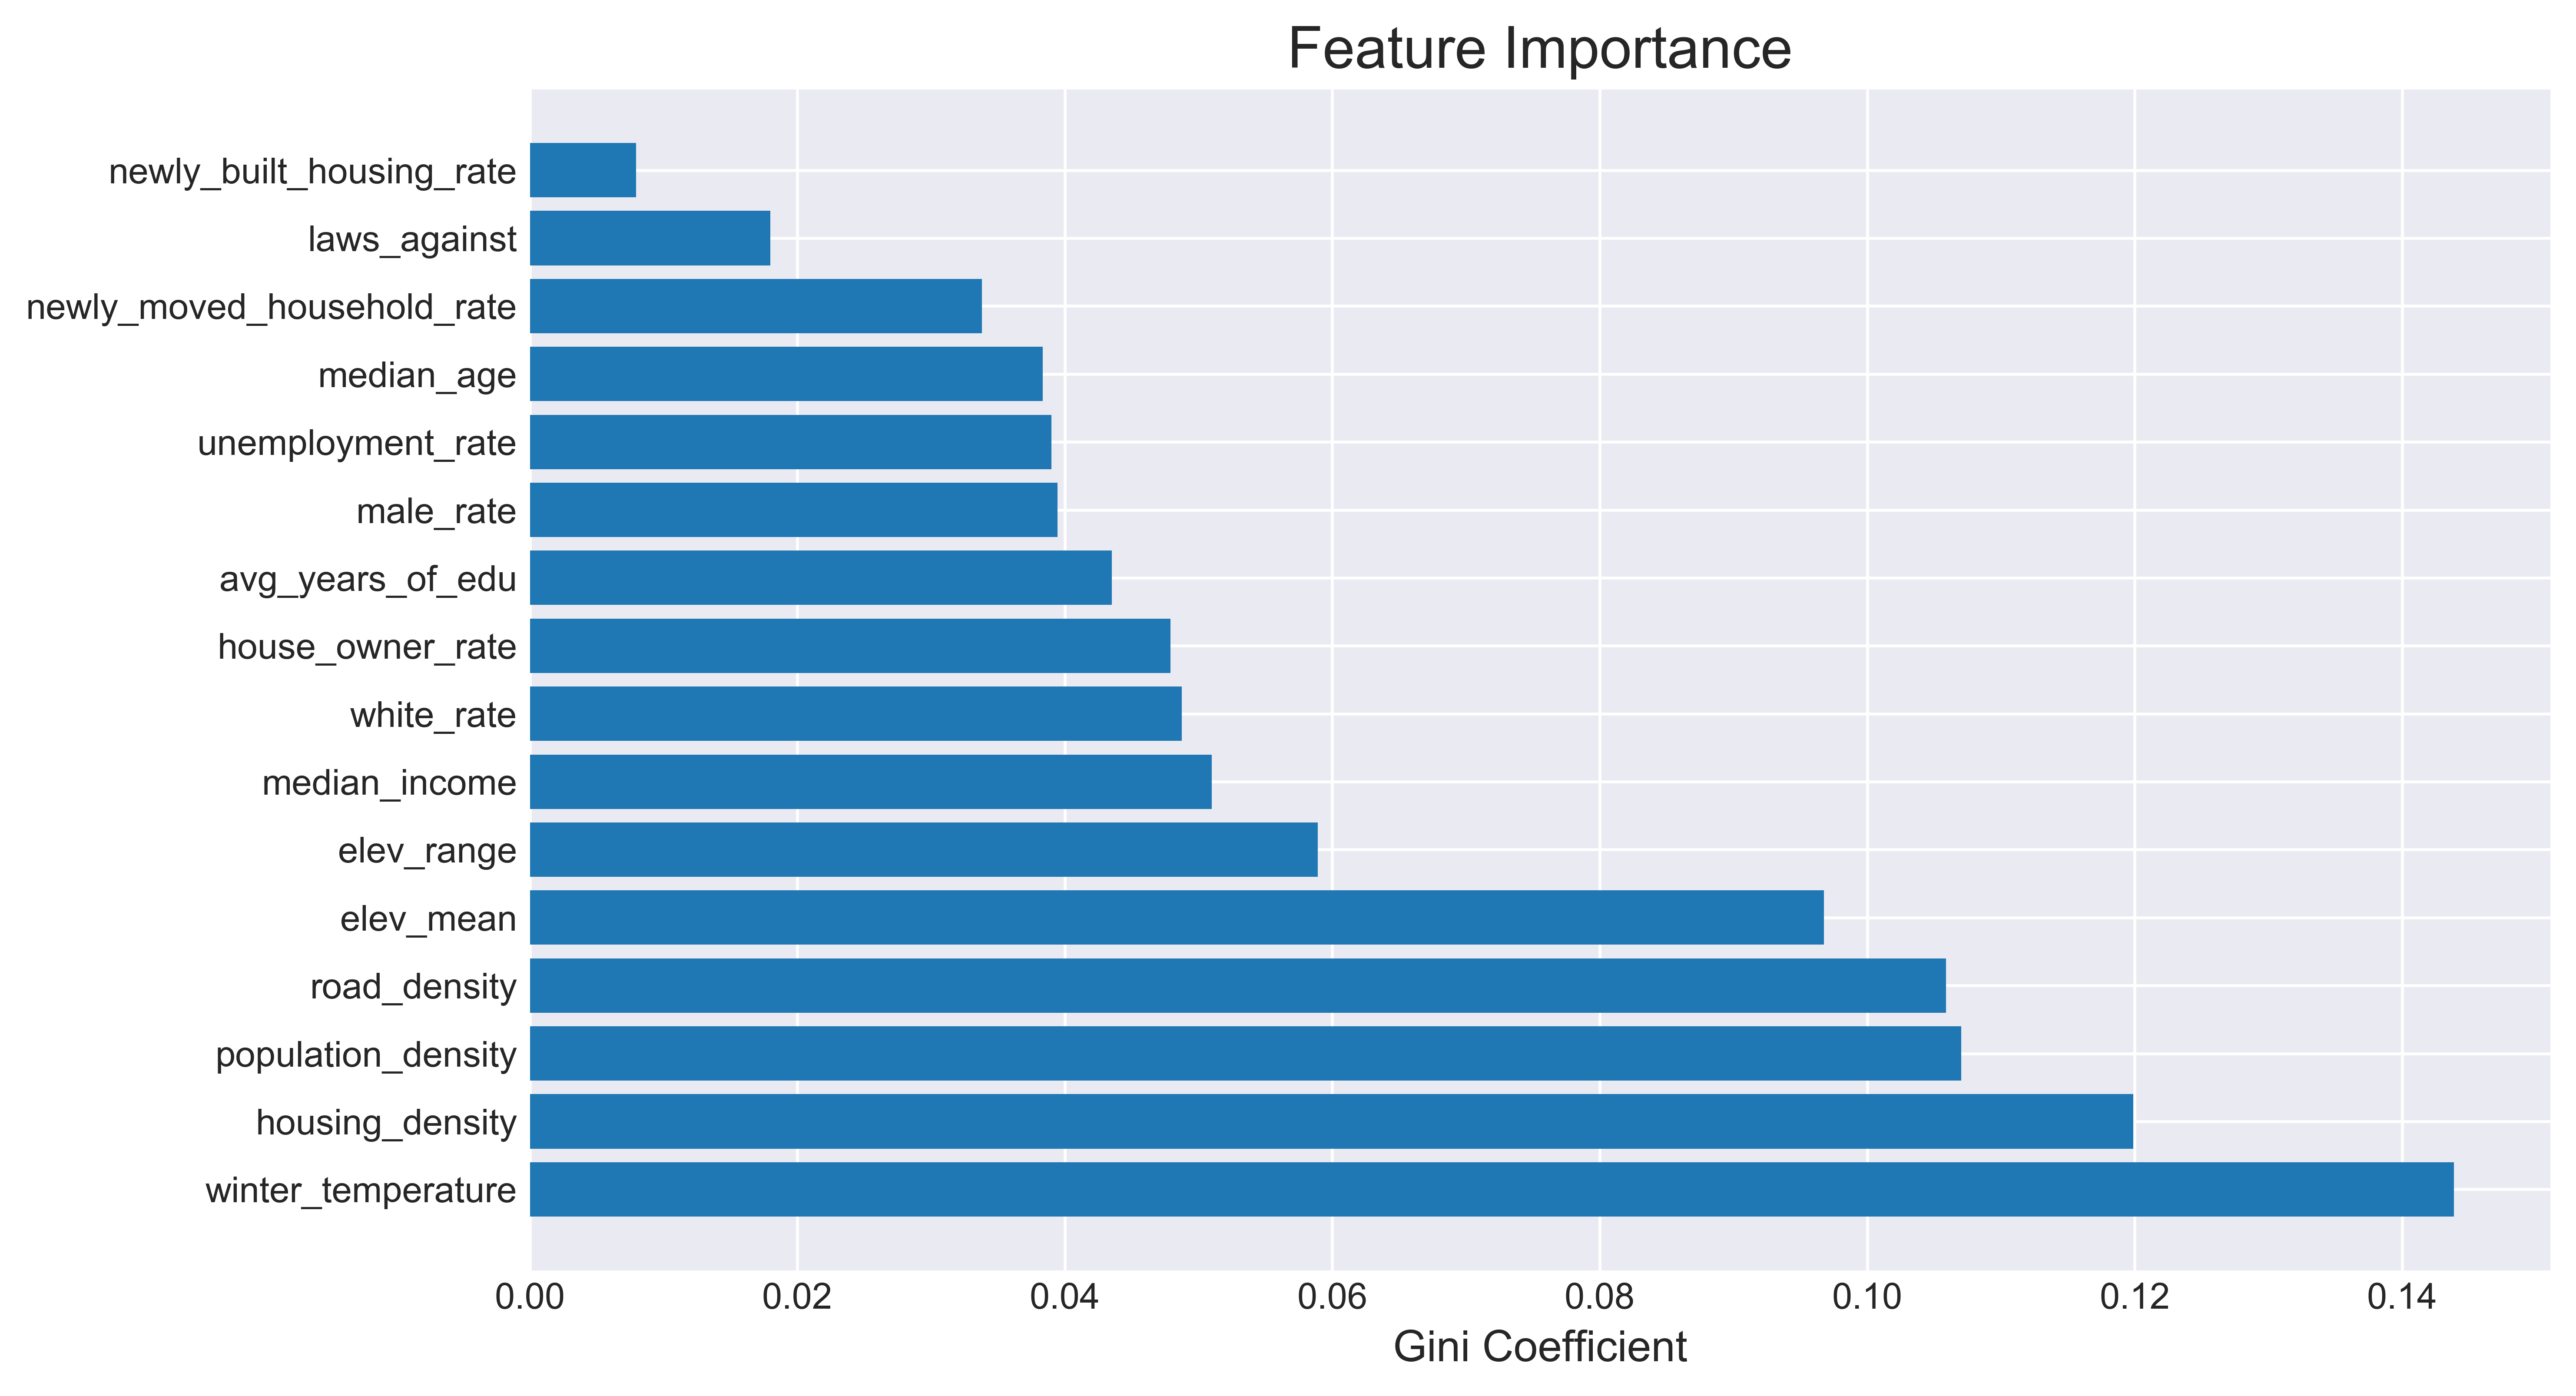

In [90]:
sns.set_style('darkgrid')
fig = plt.figure(1, figsize=(10, 6), dpi=600)
plt.barh(coef_sort['feature'], coef_sort['gini_coef'])
plt.xlabel('Gini Coefficient', fontsize=12)
plt.title('Feature Importance', fontsize=16)

# Predicting the areas that is most likely to have full coverage

In [93]:
no_full_coverage = data[~data.is_full_coverage].copy()

X_pred = no_full_coverage.drop(columns=['broad_avail_per', 'block_group', target_col])
proba = grid_search.predict_proba(X_pred)
no_full_coverage['proba'] = proba[:, 1]

cols = ['block_group', 'proba', 'broad_avail_per']
no_full_coverage = no_full_coverage[cols]

In [95]:
no_full_coverage.to_csv('broadband_prediction_result.csv', index=False)